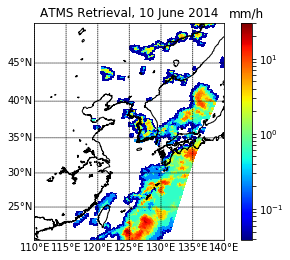

In [3]:
from os import walk
import glob
import datetime
s=datetime.datetime(2016,6,1)
import h5py as h5
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.basemap import Basemap
%matplotlib inline 
from readGPROF import *
from keras.models import load_model
model=load_model("keras_NPP_ATMS_pred_Ocean.h5")       # reads the tensorFlow ocean model valid for June,July,Aug 
model_Land=load_model("keras_NPP_ATMS_pred_Land.h5")   # reads the tensorFlow land model valid for June,July,Aug 

from  netCDF4 import Dataset
ifig=0
from pyresample import bilinear, geometry
import pickle

s=datetime.datetime(2016,6,1)
mypath='/gpmdata/'
dbL1=[]
from pyresample import kd_tree
from numpy import *
dbL1=[]

fName='Data/2A-CLIM.NPP.ATMS.GPROF2017v2.20140610-S162117-E180246.013567.V05C.HDF5'


orb=fName.split('.')[-3]
wCName='Data/1C.NPP*'+orb+'*HDF5'
fName1C=glob.glob(wCName)[0]

fgmi=Dataset(fName1C,'r')
 
stype,sfPrecip,lat,lon=readGPROF(fName)
ns,nr=lat.shape
a=np.nonzero((lon[:,nr/2]-110)*(lon[:,nr/2]-140)<0)        # finds the scan in the region of interest
b=np.nonzero((lat[:,nr/2][a]-10)*(lat[:,nr/2][a]-55)<0)
#a=[arange(600,900)]
#b=[arange(300)]

m =\
    Basemap(llcrnrlon=110,llcrnrlat=20,urcrnrlon=140,\
            urcrnrlat=50,projection='mill', resolution='i')

target_def = geometry.SwathDefinition(lons=lon[a[0][b],9:-11], \
                                      lats=lat[a[0][b],9:-11])

# the next section projects the S2,S3,S4 grid the S1 grid, which is the output grid

tc2=fgmi['S2']['Tc'][a[0][b],:,:]
lat2=fgmi['S2']['Latitude'][a[0][b],:]
lon2=fgmi['S2']['Longitude'][a[0][b],:]
source_def = geometry.SwathDefinition(lons=lon2, lats=lat2)
wf = lambda r: 1 - r/100000.0
tc11 = [kd_tree.resample_gauss(source_def,tc2[:,:,0], \
                               target_def,\
                               radius_of_influence=\
                               15e3, \
                               sigmas=10e3)]

tc3=fgmi['S3']['Tc'][a[0][b],:,:]
lat3=fgmi['S3']['Latitude'][a[0][b],:]
lon3=fgmi['S3']['Longitude'][a[0][b],:]
source_def = geometry.SwathDefinition(lons=lon3, lats=lat3)
wf = lambda r: 1 - r/100000.0
tc31 = [kd_tree.resample_gauss(source_def,tc3[:,:,0], \
                               target_def,\
                               radius_of_influence=\
                               15e3, \
                               sigmas=10e3)]

tc22=fgmi['S1']['Tc'][a[0][b],:,:]
lat22=fgmi['S1']['Latitude'][a[0][b],:]
lon22=fgmi['S1']['Longitude'][a[0][b],:]
source_def = geometry.SwathDefinition(lons=lon22, lats=lat22)
wf = lambda r: 1 - r/100000.0
tc221 = [kd_tree.resample_gauss(source_def,tc22[:,:,0], \
                               target_def,\
                               radius_of_influence=\
                               15e3, \
                               sigmas=10e3)]


tc4=fgmi['S4']['Tc'][a[0][b],:,:]
lat4=fgmi['S4']['Latitude'][a[0][b],:]
lon4=fgmi['S4']['Longitude'][a[0][b],:]
source_def = geometry.SwathDefinition(lons=lon4, lats=lat4)
tc41 = [kd_tree.resample_gauss(source_def,tc4[:,:,k], \
                               target_def,\
                               radius_of_influence=\
                               15e3, \
                               sigmas=10e3) for k in range(6)]
tc41=array(tc41)
tc11=array(tc11)
r1L=[]
r2L=[]
sfcPrecip2=sfPrecip*0
tc31=array(tc31)
tc221=array(tc221)

# iterates through scans rays and apply the tensorFlow models 

for i in a[0][b]:
    for j in range(9,85):
        if stype[i,j]>=1 and sfPrecip[i,j]>=-0.03 and \
           i-a[0][b][0] < tc11.shape[1]-1:
            i0=i-a[0][b][0]
            if tc11[:,i0,j-9].min()>0 and tc41[:,i0,j-9].min()>0\
               and \
               sfPrecip[i,j]>-0.05:
                tcL=[tc11[0,i0,j-9]]
                tcL.append(tc31[0,i0,j-9])
                tcL.extend(tc41[:,i0,j-9])
                tcL.append(j)
                tcL.append(stype[i,j])
                tcL.append(sfPrecip[i,j])
                xp=array([array(tcL[:-1])])
                if stype[i,j]==1:
                    sfRainE=model.predict(xp)[0][0]
                    if sfRainE<-0.0504:
                        sfRainE=0.
                else:
                    sfRainE=model_Land.predict(xp)[0][0]
                    if sfRainE<-0.0504:
                        sfRainE=0.
                sfcPrecip2[i,j]=sfRainE

ymin=0.0504 # the tensorFlow models cannot estimate precipitation lighter than this threshold

for i1 in a[0][b][1:-1]:
    for j in range(1,95):
        if sfcPrecip2[i1,j]<ymin and sfcPrecip2[i1-1:i1+2,j-1:j+2].max()<ymin:
            sfcPrecip2[i1,j]=0.
        if stype[i1,j]==13:
            if sfcPrecip2[i1,j]<ymin and sfcPrecip2[i1-1:i1+2,j-1:j+2].max()<0.75:
                sfcPrecip2[i1,j]=0.
        if stype[i1,j]==14:
            if sfcPrecip2[i1,j]<ymin and sfcPrecip2[i1-1:i1+2,j-1:j+2].max()<0.75:
                sfcPrecip2[i1,j]=0.

t_bias=1.2 # this is the bias estimated from the cross-validation analysis

sfcPrecip2*=t_bias
lons=lon[a[0][b],9:-11]
lats=lat[a[0][b],9:-11]
ny=lons.shape[1]
x,y=m(lons,lats)
m.drawcoastlines()
m.drawparallels(10+np.arange(8)*5,labels=[True,False,False,False])
m.drawmeridians(110+np.arange(7)*5,labels=[True,True,False,True])
plt.pcolormesh(x[:,:],y[:,:],sfcPrecip2[a[0][b],9:-11],norm=col.LogNorm(),vmax=30.,cmap='jet')
plt.title('ATMS Retrieval, 10 June 2014') 
cbar=plt.colorbar()
cbar.ax.set_title('mm/h')
plt.savefig('sfcPrecipATMS_2014_06_10.13567.png')
